In [7]:
# uncomment when usedin Colab
#! pip install simpy

In [8]:
# some constants definitions
RANDOM_SEED = 42

# ticket category dict with duration as values --- based on tickets per day
# Accounts 27 mins includes +10 according to Marta
# Supplier Check 15 mins + 10 according to Marta
# install base 17 min + 10 according to Marta
TICKET_CATEGORIES = {
    "ACCOUNT": 22,
    "ASSET": 22,
    "QA": 5,
    }

TICKET_PRIORITIES = {
    "STD": False,
    "HIGH": True,
    }

# validated with DG from Backlog file
TICKET_BACKLOG = 1781
TICKET_PREFIX = "RSS_"

# creating an array of the form
#      Jan, Feb, Mar, Apr ....
# exp = above 1.5 productivity than average
# std = between 1.5 and 0.8
# rok = between 0.3 and 0.8
ADVISORS_YEAR = [
    [14, 21, 25, 24, 24, 24, 24, 24, 24, 24, 17, 13],
    [7, 2, 4, 5, 5, 5, 5, 5, 5, 5, 7, 6],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]

# Confirmed with DG team from their spreadsheet
# TICKETS_PER_DAY = 383
# adding 10% of tickets
TICKETS_PER_DAY = 436 + 43

# also some tickets might be faster or slower than the average 
TICKET_DURATION_SIGMA = 1

# Working standards
WEEK_DAYS = 7
WORK_DAYS = 5
WORK_HOURS = 8
EFFICIENCY_FACTOR = 0.85

# if there are questions back, the OpCo needs two working days
OPCO_DURATION = 2 * WORK_HOURS * 60

# workweek minutes
WORK_DAY_MINUTES = WORK_HOURS * 60

# Calculate Ticket Frequency
TICKET_FREQUENCY = WORK_DAY_MINUTES / TICKETS_PER_DAY

#Calculate the work minutes
WORK_WEEK_MINUTES = WORK_DAY_MINUTES * WORK_DAYS

# Careful, calculating with work hours
WEEKEND_MINUTES = (WEEK_DAYS-WORK_DAYS) * WORK_DAY_MINUTES

# modify this to modify the simulation time
DAYS = 219
DAYS = 355

# Start date definition - should match with the first day
# in seasonality data file
START_DATE = '2020/10/01'

# calculate the sim time
SIM_TIME = DAYS * 8 * 60

MONITORING_TIME = WORK_DAY_MINUTES

CSV_FILE = 'log.csv'
CSV_HEADER = ['date', 'time', 'created', 'resolved', 'backlog']

SEASONALITY_TICKETS = 'seasonality_tickets.csv'
SEASONALITY_TICKET_HEADER = ['month', 'day', 'Seasonality']

SEASONALITY_ADVISORS = 'seasonality_advisors.csv'
SEASONALITY_ADVISOR_HEADER = ['month', 'day', 'Seasonality', 'expert', 'standard', 'rookie',
    'season-expert', 'season-standard', 'season-rookie']

SLA_FILE = 'sla_data.csv'
SLA_HEADER = ['advisor_id', 'ticket_id', 'category', 'start_time', 'end_time']

SAVINGS = 0.95

In [9]:
# main class definitions here
from os import sep
import simpy
import random
from time import sleep
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta, date

class Tracker:
    def __init__(self, env):
        self.env = env
        try:
            with open(CSV_FILE, mode='w', newline='') as logfile:
                writer = csv.writer(logfile, delimiter=';')
                writer.writerow(CSV_HEADER)
            with open(SLA_FILE, mode='w', newline='') as slafile:
                writer = csv.writer(slafile, delimiter=';')
                writer.writerow(SLA_HEADER)
        except OSError:
            print('Can\'t open log file!')

    def track_status(self, stats):
        # append the ticket data to the file
        self.write_row(CSV_FILE, stats)
    
    def track_sla(self, stats):
        # append the sla data to the file
        self.write_row(SLA_FILE, stats)

    def write_row(self, file, row):
        with open(file, mode='a', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow(row.values())

class Ticket:
    """create a ticket with a random category and random priority"""
    def __init__(self, now):
        # randomly create a ticket
        accessor = random.randint(0, len(TICKET_CATEGORIES) - 1)
        i = 0
        for key, value in TICKET_CATEGORIES.items():
            if i == accessor:
                self.category = key
                self.duration = value
                self.time = now
                break
            i += 1

    def set_id(self, id):
        self.id = TICKET_PREFIX + str(id)

    def get_id(self):
        return self.id

    def get_category(self):
        return self.category

    def get_creation_time(self):
        return self.time

    def get_duration(self):
        return self.duration

# Class definition for department
class Ticket_system:
    """store system which allows to receive and give out tickets
    initial_backlog = backlog at start of simulation
    backlog = current backlog
    """

    def __init__(self, env, init_backlog, tracker, clock):
        self.env = env
        self.clock = clock
        self.tracker = tracker
        self.store = simpy.Store(env, capacity=simpy.core.Infinity)
        # fill the store with the initial backlog
        self.id_num = 0
        self.backlog = 0
        self.clear_stats()
        while self.id_num < init_backlog:
            ticket = Ticket(self.env.now)
            self.put_ticket(ticket)

    def get_backlog(self):
        return len(self.store.items)
    
    def get_statistics(self):
        stats = {
            'date': self.clock.get_date(),
            'time': self.env.now,
            'created': self.created,
            'resolved': self.resolved,
            'backlog': self.get_backlog(),
        }
        self.clear_stats()
        return stats

    def clear_stats(self):
        self.created = 0
        self.resolved = 0

    def put_ticket(self, ticket):
        # generate an ID before storing it
        ticket.set_id(self.id_num)
        self.store.put(ticket)
        self.id_num += 1
        self.created += 1

    def generate_id(self):
        return TICKET_PREFIX + str(self.id_num)

    def get_ticket(self):
        ticket = self.store.get()
        self.resolved += 1
        return ticket

class Company_resource:
    ''' a generic base class for company resources
    implements the weekend_controller
    '''
    def __init__(self, env, clock):
        self.env = env
        self.clock = clock
        self.weekend = False
        self.env.process(self.weekend_controller())

    def weekend_controller(self):
        while True:
            yield self.clock.start_weekend
            self.weekend = True
            yield self.clock.end_weekend
            self.weekend = False

class Customer(Company_resource):
    """Class that randomly tickets based on frequency
    tickets have priority set, and are stored in the TicketSystem
    tickets can have different categories, depending on category
    it takes more or less time.
    Inherits from Company_resource class the weekend methods
    """

    def __init__(self, env, snow, clock, seasonality):
        # calling the parents __init__
        super().__init__(env, clock)
        self.tickets_created = 0
        self.env = env
        self.snow = snow
        self.clock = clock
        self.wait_time = TICKET_FREQUENCY
        self.seasonality = seasonality
        env.process(self.start_ticket_creation())

    def start_ticket_creation(self):
        mydate = date(1970, 10, 26)
        day = 0
        previous_day = 42
        # get the current day number
        while True:
            mydate = self.clock.get_date()
            day = mydate.day
            # self.weekend is coming from the parent class
            if not self.weekend:
                self.create_ticket()
                # getting the seasonality if it is a new day
                if day != previous_day:
                    self.wait_time = TICKET_FREQUENCY * self.get_timeout(mydate)
                    previous_day = day
                yield self.env.timeout(self.wait_time)
            else:
                yield self.clock.end_weekend

    def get_timeout(self, date):
        return self.seasonality.get_ticket_seasonality(date)
    
    def create_ticket(self):
        # create a fresh ticket object
        ticket = Ticket(self.env.now)
        self.snow.put_ticket(ticket)
        self.tickets_created += 1

    def get_num_tickets_created(self):
        return self.tickets_created

class Seasonality():
    """ seasonality model - reads seasonality data into a dataframe
    based on that dataframe, the ticket frequency will be changed
    Seasonality data must be in the form of:
    Month, Day, % of normal ticket rate
    """
    def __init__(self):
        self.day = 0
        self.last_good_day = 0
        self.seasonality = 1
        self.df_tickets = pd.read_csv(SEASONALITY_TICKETS, sep=';')
        self.df_advisors = pd.read_csv(SEASONALITY_ADVISORS, sep=';')

    def get_ticket_seasonality(self, mydate):
        # get the day and month from the date object
        day = mydate.day
        month = mydate.month
        try:
            # seasonality is in the form of 1.23243 we need to get the inverse
            # value 1/seasonality
            self.seasonality = 1/self.df_tickets.loc[(self.df_tickets['day'] == day) & 
                (self.df_tickets['month'] == month), ['Seasonality']].Seasonality.item()
        # if the day does not exist in seasonality data, most probably, because
        # it was weekend
        except ValueError:
            self.seasonality = 1000
        return self.seasonality

    def get_advisor_seasonality(self, month, day, advisor_level):
        # get the day and month from the date object
        try:
            # seasonality is in the form of 1.23243 we need to get the inverse
            # value 1/seasonality
            self.seasonality = self.df_advisors.loc[(self.df_advisors['day'] == day) & 
                (self.df_advisors['month'] == month), advisor_level].values[0]
        # if the day does not exist in seasonality data, most probably, because
        # it was weekend
        except ValueError:
            self.seasonality = 0
        return self.seasonality

class Clock:
    """ clock that triggers the advisors to go to weekend every 
    5 * 24 * 60 minutes
    """
    def __init__(self, env, start_date):        
        self.env = env
        self.date = datetime.strptime(start_date, '%Y/%m/%d')
        # monitor the days to get the weekends
        self.env.process(self.day_controller())
        # monitor the months, so every month we create new advisors
        self.env.process(self.month_controller())
        """ create the weekend event """
        self.start_weekend = env.event()
        self.end_weekend = env.event()
        # create the monthend event
        self.start_advisor = env.event()
        self.end_advisor = env.event()
    
    def day_controller(self):
        # in case the first day is a saturday
        previous_day = 4
        day = self.date.weekday()
        while True:
            # Monday is 0 and Sunday is 6 --> weekend
            if (day == 5) and (previous_day == 4):
                # trigger the event and setup a new one
                self.start_weekend.succeed()
                self.start_weekend = self.env.event()
            if (day == 0) and (previous_day == 6):
                # trigger the event and setup a new one
                self.end_weekend.succeed()
                self.end_weekend = self.env.event()
            # wait for the end of the day
            yield self.env.timeout(WORK_DAY_MINUTES)
            # now set the new day
            self.date = self.date + timedelta(days=1)
            previous_day = day
            day = self.date.weekday()

    def month_controller(self):
        current_day = self.date.day
        while True:
            if current_day != self.date.day:
                # now the day changed we fire the end month event
                self.end_advisor.succeed()
                # setup a new event
                self.end_advisor = self.env.event()
                current_day = self.date.day
            # wait for a day
            yield self.env.timeout(WORK_DAY_MINUTES)

    def get_date(self):
       return self.date

class Advisor(Company_resource):
    """ resource that gets ticket from store analyses the category,
    duration, and priority, based on that and the Advisor level,
    the ticket duration is calculated
    Inherits from Ricoh_resource
    """

    def __init__(self, env, ticket_system, level, id, clock, tracker):
        super().__init__(env, clock)
        self.env = env
        self.ts = ticket_system
        self.level = level
        self.tickets_processed = 0
        self.id = id
        self.tracker = tracker
        self.start_time = 0
        self.end_time = 0
        # is the advisor active?
        self.active = True
        # start processing next ticket
        self.env.process(self.process_tickets())

    def process_tickets(self):
        while self.active:
            # take a ticket out
            if not self.weekend:
                ticket = yield self.ts.get_ticket()
                self.start_time = self.env.now
                duration = abs(self.calculate_ticket_duration(ticket))
                yield self.env.timeout(duration)
                # write data to SLA file
                self.end_time = self.env.now
                sla_data = {
                    'advisor_id': self.id,
                    'ticket_id': ticket.get_id(),
                    'category': ticket.get_category(),
                    'start_time': ticket.get_creation_time(),
                    'end_time': self.end_time,
                }
                self.tracker.track_sla(sla_data)
                self.tickets_processed += 1
            else:
                yield self.clock.end_weekend
    
    def deactivate_advisor(self):
        """ call this to deactivate the advisor
        """        
        self.active = False

    def calculate_ticket_duration(self, ticket):
        """calculate duration based on level of advisor and ticket
        duration + a random standard deviation
        """ 
        if self.level == "EXP":
            std_deviation = -4
        elif self.level == "STD":
            std_deviation = 0
        else:
            std_deviation = +12            
        return ticket.get_duration()

        # uncomment if we want variable ticket durations
        #return std_deviation + random.normalvariate(ticket.get_duration(), \
        #        TICKET_DURATION_SIGMA)
    
    def get_id(self):
        return self.id

    def get_level(self):
        return self.level

    def get_processed(self):
        return self.tickets_processed

class Human_resources():
    """ HR class that is creating and deactivating the advisors """
    def __init__(self, env, ticket_system, clock, tracker, seasonality):
        self.advisors = []
        self.last_id = 0
        self.env = env
        self.clock = clock
        self.ticket_system = ticket_system
        self.tracker = tracker
        self.seasonality = seasonality
        self.create_advisors()
        self.env.process(self.month_change_controller())

    def month_change_controller(self):
        while True:
            yield self.clock.end_advisor
            print("A new day started: ", self.clock.get_date())
            self.deactivate_advisors()
            self.create_advisors()

    def deactivate_advisors(self):
        for a in self.advisors:
            if a.active:
               a.deactivate_advisor()
    
    def create_advisors(self):
        level = ["season-expert", "season-standard", "season-rookie",]
        # uncomment to use the actual level without the seasonality
        # level = ["expert", "standard", "rookie",]
        month = self.clock.get_date().month
        day = self.clock.get_date().day
        weekday = self.clock.get_date().weekday()
        if not(weekday == 5 or weekday == 6): 
            for level_name in enumerate(level):
                num = int(self.seasonality.get_advisor_seasonality(month, day, level_name[1])*SAVINGS)
                for i in range(0, num):
                    id = level_name[1] + str(self.last_id)
                    self.last_id += 1
                    self.advisors.append(Advisor(self.env, self.ticket_system, level[1], id, self.clock, self.tracker))
        else:
            print("HR does not hire on weekends!")

def monitoring_process(env, ticket_system, tracker, wait):
    """periodically report on backlog"""
    while True:
        # print(f"Backlog at {env.now} is: {ticket_system.get_backlog()}")
        tracker.track_status(ticket_system.get_statistics())
        yield env.timeout(wait)

In [10]:
# main program
def main():
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    tracker = Tracker(env)
    # create a clock that controls the weekend
    clock = Clock(env, START_DATE)
    # TODO: change the backlog default to a number entered by user
    ticket_system = Ticket_system(env, TICKET_BACKLOG, tracker, clock)
    # create a seasonality object
    seasonality = Seasonality()
    # create the HR process hires and fires advisors
    hr = Human_resources(env, ticket_system, clock, tracker, seasonality)    
    # create an OpCo instance who creates tickets
    customer = Customer(env, ticket_system, clock, seasonality)
    # setup some monitoring that returns the backlog state
    env.process(monitoring_process(env, ticket_system, tracker, MONITORING_TIME))
    # start the simulation
    env.run(until=SIM_TIME)
    # print how many tickets each advisor processed
    for a in hr.advisors:
        print(
            f"Advisor: {a.get_id()}, processed {a.get_processed()} tickets"
        )

    print(f"The backlog at the end is: {ticket_system.get_backlog()}")
    print(f"The OpCo created: {customer.get_num_tickets_created()} tickets")

if __name__ == "__main__":
    # 
    main()

A new day started:  2020-10-02 00:00:00
A new day started:  2020-10-03 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-04 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-05 00:00:00
A new day started:  2020-10-06 00:00:00
A new day started:  2020-10-07 00:00:00
A new day started:  2020-10-08 00:00:00
A new day started:  2020-10-09 00:00:00
A new day started:  2020-10-10 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-11 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-12 00:00:00
A new day started:  2020-10-13 00:00:00
A new day started:  2020-10-14 00:00:00
A new day started:  2020-10-15 00:00:00
A new day started:  2020-10-16 00:00:00
A new day started:  2020-10-17 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-18 00:00:00
HR does not hire on weekends!
A new day started:  2020-10-19 00:00:00
A new day started:  2020-10-20 00:00:00
A new day started:  2020-10-21 00:00:00
A new day started:  

In [11]:
# import visualisation stuff
import matplotlib
import matplotlib.pyplot as plt

# now we open the log file csv
df = pd.read_csv(CSV_FILE, sep=';')

# generate a date-time out of the env-time columnn
df['time2'] = df['time'] / 20
df['datetime'] = pd.to_timedelta(df['time2'], unit='h') + pd.Timestamp(START_DATE)

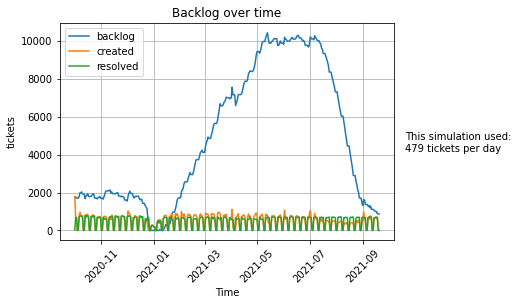

In [12]:
# prepare the plot

t = df.loc[:, 'datetime']
b = df.loc[:, 'backlog']
c = df.loc[:, 'created']
r = df.loc[:, 'resolved']

fig, ax = plt.subplots()
line1, = ax.plot(t, b, label='backlog')
line2, = ax.plot(t, c, label='created')
line3, = ax.plot(t, r, label='resolved')

x_loc = t.max() + timedelta(days=30)
y_loc = b.max()/2
text = f'This simulation used: \n{TICKETS_PER_DAY} tickets per day'

ax.set(xlabel='Time', ylabel='tickets', title='Backlog over time')
ax.grid()
ax.legend()
ax.text(x_loc, y_loc, text, horizontalalignment='left', verticalalignment='top')
plt.xticks(rotation='45')
plt.show()